In [ ]:
# pip3 install torch transformers librosa accelerate 

In [1]:
# clear GPU cache before importing large libraries
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [2]:
import librosa
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
import os
import pandas as pd

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


In [4]:
repo_id = "MERaLiON/MERaLiON-2-3B"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#  clear GPU cache before loading model
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Loading processor...")
processor = AutoProcessor.from_pretrained(repo_id, trust_remote_code=True)

print("Loading model...")
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    repo_id,
    use_safetensors=True,
    trust_remote_code=True,
    attn_implementation="eager",   # <--- force eager attention
    torch_dtype=torch.bfloat16 if device=="cuda" else torch.float32,
).to(device)

print("Model loaded successfully!")

Using device: cuda
Loading processor...
Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully!


In [5]:
prompt_template = (
    "Instruction: Please transcribe this speech. \n"
    "Follow the text instruction based on the following audio: <SpeechHere>"
)
conversation = [[{"role": "user", "content": prompt_template}]]
chat_prompt = processor.tokenizer.apply_chat_template(
    conversation=conversation, tokenize=False, add_generation_prompt=True
)


In [6]:
def process_audio_file(audio_path, queries=None):
    """
    Process audio file with given queries (memory-efficient version)
    
    Args:
        audio_path: Path to your audio file
        queries: List of query strings (defaults to transcribe and translate)
    """
    
    # Check if file exists
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")
    
    print(f"Loading audio: {audio_path}")
    
    # Load audio at 16kHz
    audio_array, sample_rate = librosa.load(audio_path, sr=16000)
    print(f"Audio loaded: {len(audio_array)/sample_rate:.2f} seconds")

    # only process first 30 seconds
    audio_array = audio_array[:30 * sample_rate]
    print(f"Processing first {len(audio_array)/sample_rate:.2f} seconds of audio")
    
    inputs = processor(text=chat_prompt, audios=[audio_array])
    for k, v in list(inputs.items()):
        if isinstance(v, torch.Tensor):
            v = v.to(device)
            if device=="cuda" and v.dtype==torch.float32:
                v = v.to(torch.bfloat16)
            inputs[k] = v

    # --- Generate transcription ---
    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=256)

    generated_ids = outputs[:, inputs["input_ids"].size(1):]
    transcript = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # clear GPU cache after processing
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("--------------------------------------------")
    return transcript

# Getting transcription

In [7]:
AUDIO_FILE_PATH = "data/fairness/audio" # path to fairness audio files

try:
    # Process the audio files
    results = []
    audios = []
    for audio_file in os.listdir(AUDIO_FILE_PATH):
        if audio_file.endswith(".wav") or audio_file.endswith(".mp3"):
            full_path = os.path.join(AUDIO_FILE_PATH, audio_file)
            audios.append(audio_file)
            print(f"Processing file: {full_path}")
    
            results.append(process_audio_file(full_path))
            
    # save results in an excel file with columns filename, transcript
    df = pd.DataFrame({"Filename": audios, "Transcription": results})
    df.to_excel("results/fairness/transcription_results.xlsx", index=False)

    print("Transcription results saved to results/fairness/transcription_results.xlsx")

except Exception as e:
    print(f"An error occurred: {e}")


Processing file: data/fairness/audio\test1.mp3
Loading audio: data/fairness/audio\test1.mp3
Audio loaded: 96.67 seconds
Processing first 30.00 seconds of audio


C:\Users\65900\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\whisper\feature_extraction_whisper.py:182: RuntimeWarning: Mean of empty slice.
  normed_slice = (vector - vector[:length].mean()) / np.sqrt(vector[:length].var() + 1e-7)
C:\Users\65900\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\65900\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\whisper\feature_extraction_whisper.py:182: RuntimeWarning: Degrees of freedom <= 0 for slice
  normed_slice = (vector - vector[:length].mean()) / np.sqrt(vector[:length].var() + 1e-7)
C:\Users\65900\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

--------------------------------------------
Processing file: data/fairness/audio\test10.mp3
Loading audio: data/fairness/audio\test10.mp3
Audio loaded: 102.47 seconds
Processing first 30.00 seconds of audio
--------------------------------------------
Processing file: data/fairness/audio\test2.mp3
Loading audio: data/fairness/audio\test2.mp3
Audio loaded: 103.86 seconds
Processing first 30.00 seconds of audio
--------------------------------------------
Processing file: data/fairness/audio\test21.mp3
Loading audio: data/fairness/audio\test21.mp3
Audio loaded: 53.01 seconds
Processing first 30.00 seconds of audio
--------------------------------------------
Processing file: data/fairness/audio\test22.mp3
Loading audio: data/fairness/audio\test22.mp3
Audio loaded: 22.99 seconds
Processing first 22.99 seconds of audio
--------------------------------------------
Processing file: data/fairness/audio\test23.mp3
Loading audio: data/fairness/audio\test23.mp3
Audio loaded: 37.72 seconds
Proce

In [ ]:
process_audio_file(f'{AUDIO_FILE_PATH}/test28.mp3') # for specific file testing

Loading audio: audio/test28.mp3
Audio loaded: 1561.24 seconds
Processing first 30.00 seconds of audio
--------------------------------------------


"<Speaker1>: Singapore president Halimah Yacob is just about to address the country's parliament as it reopens after a recess of a little more than two weeks. The recess, which happens when parliament is prorogued, typically marks the midpoint of the government's current term. Madam Halimah is expected to outline the government's priorities, policies and programs ahead of the remainder of its term. Her speech comes as the nation rebounds from the impact of Covid Nineteen, but with the spectre of geopolitical tensions.\n"

# Result Evaluation

In [1]:
import pandas as pd

# read the transcription results
df = pd.read_excel("results/fairness/transcription_results.xlsx")
df.head()

,Filename,Transcription
0,test1.mp3,<Speaker1>: It's my final day here in Switzerl...
1,test10.mp3,<Speaker1>: I'm in Paris and I want to do some...
2,test2.mp3,<Speaker1>: I did it. I got the iPhone Air. Lo...
3,test21.mp3,"<Speaker1>: Brian, look at me. This is not you..."
4,test22.mp3,<Speaker1>: I designed this yoga bag and it wa...


In [2]:
metadata = pd.read_excel("results/fairness/metadata.xlsx")

In [3]:
metadata.head()


,Filename,meralion,Added by,Video,Gender,Race,Age,GT,Accuracy
0,test1.mp3,<Speaker1>: It's my final day here in Switzerl...,yy,https://www.instagram.com/reel/DO7kMR-Exnm/?ut...,F,Chinese,31,<Speaker1>: It's my final day here in Switzerl...,NaN
1,test10.mp3,<Speaker1>: I'm in Paris and I want to do some...,yy,https://www.tiktok.com/@zakiv4/video/754969856...,M,Malay,30,<Speaker1>: I'm in Paris and I want to do some...,NaN
2,test2.mp3,<Speaker1>: I did it. I got the iPhone Air. Lo...,yy,https://www.tiktok.com/@thejianhaotan/video/75...,M,Chinese,32,<Speaker1>: I did it. I got the iPhone Air. Lo...,NaN
3,test21.mp3,"<Speaker1>: Brian, look at me. This is not you...",yun si,https://www.tiktok.com/@syapls/video/752244596...,F,Malay,28,"<Speaker1>: Brian, look at me. This is not you...",NaN
4,test22.mp3,<Speaker1>: I designed this yoga bag and it wa...,yun si,https://www.instagram.com/p/DA8ZO6Wy-Kx/,F,Chinese,34,<Speaker1>: I designed this yoga bag and it wa...,NaN


In [11]:
# calc WER & CER base on GT & meralion output
!pip install jiwer

from typing import Dict
import numpy as np
from jiwer import wer, cer

def compute_metrics(reference: str, hypothesis: str) -> Dict[str, float]:
    return {
        "wer": wer(reference, hypothesis),
        "cer": cer(reference, hypothesis),
    }

metrics = []
for index, row in df.iterrows():
    filename = row["Filename"]
    hypothesis = row["Transcription"]
    reference_row = metadata[metadata["Filename"] == filename]
    if not reference_row.empty:
        reference = reference_row.iloc[0]["GT"]
        metrics.append(compute_metrics(reference, hypothesis))
    else:
        print(f"Warning: No reference found for {filename}")

metrics_df = pd.DataFrame(metrics)
metrics_df["Filename"] = df["Filename"]
metrics_df["Audio_Path"] = "data/fairness/audio/" + metrics_df["Filename"]
metrics_df['Race'] = metrics_df['Filename'].apply(lambda x: metadata[metadata["Filename"] == x].iloc[0]["Race"] if not metadata[metadata["Filename"] == x].empty else "")
metrics_df['Age'] = metrics_df['Filename'].apply(lambda x: metadata[metadata["Filename"] == x].iloc[0]["Age"] if not metadata[metadata["Filename"] == x].empty else "")
metrics_df['Gender'] = metrics_df['Filename'].apply(lambda x: metadata[metadata["Filename"] == x].iloc[0]["Gender"] if not metadata[metadata["Filename"] == x].empty else "")
metrics_df["Meralion_Transcription"] = df["Transcription"]
metrics_df["GT"] = metrics_df.apply(
    lambda row: metadata[metadata["Filename"] == row["Filename"]].iloc[0]["GT"] 
    if not metadata[metadata["Filename"] == row["Filename"]].empty else "",
    axis=1
)
metrics_df["WER"] = metrics_df["wer"]
metrics_df["CER"] = metrics_df["cer"]

# Reorder columns for better readability
metrics_df = metrics_df[["Filename", "Audio_Path","Race", "Age", "Gender", "GT", "Meralion_Transcription", "WER", "CER"]]



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\65900\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
metrics_df

,Filename,Audio_Path,Race,Age,Gender,GT,Meralion_Transcription,WER,CER
0,test1.mp3,data/fairness/audio/test1.mp3,Chinese,31,F,<Speaker1>: It's my final day here in Switzerl...,<Speaker1>: It's my final day here in Switzerl...,0.009346,0.001815
1,test10.mp3,data/fairness/audio/test10.mp3,Malay,30,M,<Speaker1>: I'm in Paris and I want to do some...,<Speaker1>: I'm in Paris and I want to do some...,0.007353,0.002817
2,test2.mp3,data/fairness/audio/test2.mp3,Chinese,32,M,<Speaker1>: I did it. I got the iPhone Air. Lo...,<Speaker1>: I did it. I got the iPhone Air. Lo...,0.000000,0.000000
3,test21.mp3,data/fairness/audio/test21.mp3,Malay,28,F,"<Speaker1>: Brian, look at me. This is not you...","<Speaker1>: Brian, look at me. This is not you...",0.250000,0.193133
4,test22.mp3,data/fairness/audio/test22.mp3,Chinese,34,F,<Speaker1>: I designed this yoga bag and it wa...,<Speaker1>: I designed this yoga bag and it wa...,0.000000,0.000000
5,test23.mp3,data/fairness/audio/test23.mp3,Malay,32,M,<Speaker1>: Take a look at Speedian's Gym Mons...,<Speaker1>: Take a look at Speedian's Gym Mons...,0.054348,0.025830
6,test24.mp3,data/fairness/audio/test24.mp3,Indian,57,M,<Speaker1>: And then one day there were six of...,<Speaker1>: And then one day there were six of...,0.111111,0.075269
7,test25.mp3,data/fairness/audio/test25.mp3,Chinese,31,F,<Speaker1>: Cats and dogs are evolving to look...,<Speaker1>: Cats and dogs are evolving to look...,0.053571,0.037147
8,test26.mp3,data/fairness/audio/test26.mp3,Indian,24,F,<Speaker1>: My like personality is just tired ...,<Speaker1>: My like personality is just tired ...,0.029412,0.012723
9,test27.mp3,data/fairness/audio/test27.mp3,Malay,30s,M,<Speaker1>: Men are not supposed to flirt with...,<Speaker1>: Men are not supposed to flirt with...,0.000000,0.000000


C:\Users\65900\AppData\Local\Temp\ipykernel_6908\3879895676.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gender", y="WER", data=metrics_df, ax=axes[0, 0], palette="Set2", width=0.6)
C:\Users\65900\AppData\Local\Temp\ipykernel_6908\3879895676.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gender", y="CER", data=metrics_df, ax=axes[0, 1], palette="Set2", width=0.6)
C:\Users\65900\AppData\Local\Temp\ipykernel_6908\3879895676.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Race", y="WER", data=metrics_df, ax=axes[1, 0

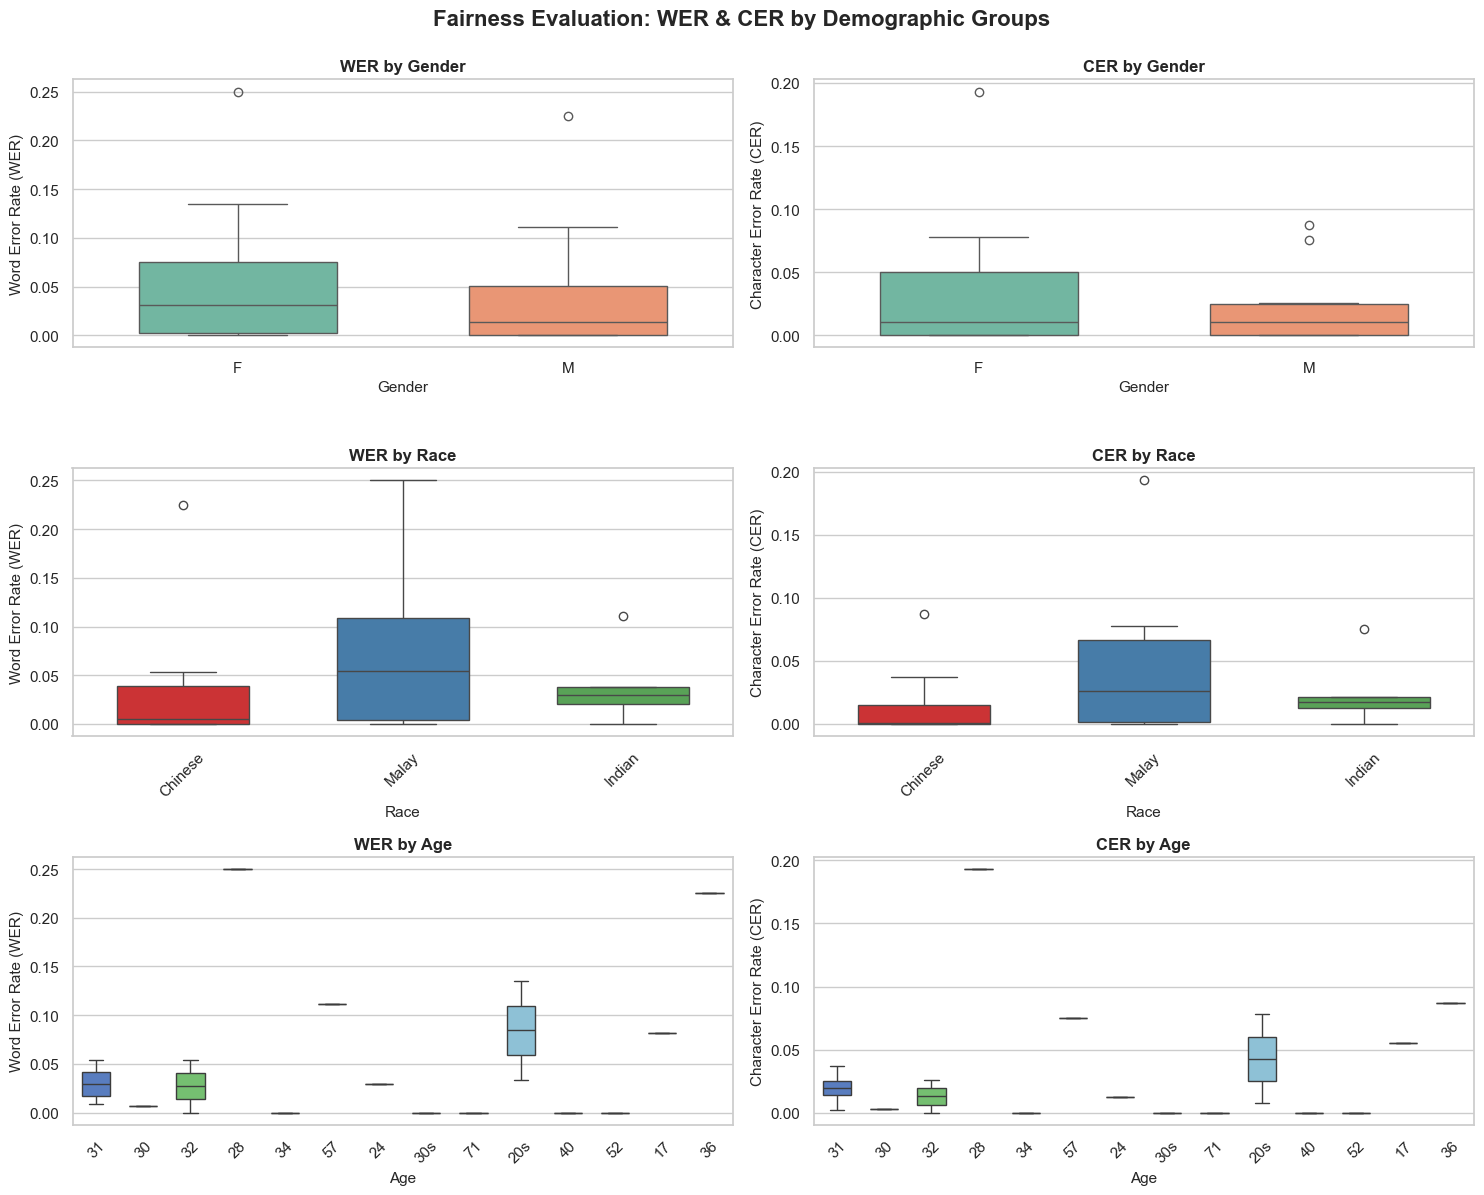


FAIRNESS EVALUATION SUMMARY STATISTICS

📊 WER & CER by Gender:
          WER                       CER                   
         mean    std  min    max   mean    std  min    max
Gender                                                    
F       0.059  0.080  0.0  0.250  0.039  0.061  0.0  0.193
M       0.046  0.072  0.0  0.225  0.023  0.032  0.0  0.087

📊 WER & CER by Race:
           WER                       CER                   
          mean    std  min    max   mean    std  min    max
Race                                                       
Chinese  0.040  0.077  0.0  0.225  0.017  0.031  0.0  0.087
Indian   0.040  0.042  0.0  0.111  0.025  0.029  0.0  0.075
Malay    0.076  0.092  0.0  0.250  0.051  0.070  0.0  0.193

📊 WER & CER by Age:
       WER                         CER                     
      mean    std    min    max   mean    std    min    max
Age                                                        
17   0.082    NaN  0.082  0.082  0.055    NaN  0.055  0.05

In [14]:
# visualise WER & CER by gender, age, race - enhanced visuals
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set style for better-looking plots
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.facecolor'] = 'white'

# Create a comprehensive 3x2 figure
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Fairness Evaluation: WER & CER by Demographic Groups', fontsize=16, fontweight='bold', y=0.995)

# Row 1: Gender
sns.boxplot(x="Gender", y="WER", data=metrics_df, ax=axes[0, 0], palette="Set2", width=0.6)
axes[0, 0].set_title("WER by Gender", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Gender", fontsize=11)
axes[0, 0].set_ylabel("Word Error Rate (WER)", fontsize=11)

sns.boxplot(x="Gender", y="CER", data=metrics_df, ax=axes[0, 1], palette="Set2", width=0.6)
axes[0, 1].set_title("CER by Gender", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Gender", fontsize=11)
axes[0, 1].set_ylabel("Character Error Rate (CER)", fontsize=11)

# Row 2: Race
sns.boxplot(x="Race", y="WER", data=metrics_df, ax=axes[1, 0], palette="Set1", width=0.6)
axes[1, 0].set_title("WER by Race", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Race", fontsize=11)
axes[1, 0].set_ylabel("Word Error Rate (WER)", fontsize=11)
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(x="Race", y="CER", data=metrics_df, ax=axes[1, 1], palette="Set1", width=0.6)
axes[1, 1].set_title("CER by Race", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Race", fontsize=11)
axes[1, 1].set_ylabel("Character Error Rate (CER)", fontsize=11)
axes[1, 1].tick_params(axis='x', rotation=45)

# Row 3: Age
sns.boxplot(x="Age", y="WER", data=metrics_df, ax=axes[2, 0], palette="muted", width=0.6)
axes[2, 0].set_title("WER by Age", fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel("Age", fontsize=11)
axes[2, 0].set_ylabel("Word Error Rate (WER)", fontsize=11)
axes[2, 0].tick_params(axis='x', rotation=45)

sns.boxplot(x="Age", y="CER", data=metrics_df, ax=axes[2, 1], palette="muted", width=0.6)
axes[2, 1].set_title("CER by Age", fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel("Age", fontsize=11)
axes[2, 1].set_ylabel("Character Error Rate (CER)", fontsize=11)
axes[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("FAIRNESS EVALUATION SUMMARY STATISTICS")
print("="*70)

print("\n📊 WER & CER by Gender:")
print(metrics_df.groupby("Gender")[["WER", "CER"]].agg(["mean", "std", "min", "max"]).round(3))

print("\n📊 WER & CER by Race:")
print(metrics_df.groupby("Race")[["WER", "CER"]].agg(["mean", "std", "min", "max"]).round(3))

print("\n📊 WER & CER by Age:")
print(metrics_df.groupby("Age")[["WER", "CER"]].agg(["mean", "std", "min", "max"]).round(3))
